In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from util.data_utils import create_seq_db_filter_top_k, sequences_to_spfm_format
from util.split import last_session_out_split
from util.metrics import precision, recall, mrr
from util import evaluation
from recommenders.RNNRecommender import RNNRecommender

In [3]:
import datetime

In [4]:
def get_test_sequences_and_users(test_data, given_k, train_users):
    # we can run evaluation only over sequences longer than abs(LAST_K)
    mask = test_data['sequence'].map(len) > abs(given_k)
    mask &= test_data['user_id'].isin(train_users)
    test_sequences = test_data.loc[mask, 'sequence'].values
    test_users = test_data.loc[mask, 'user_id'].values
    return test_sequences, test_users

<a id='load_the_dataset'></a>

# 1. Load the dataset



In [5]:
# unzip the dataset, if you haven't already done it
# ! unzip datasets/sessions.zip -d datasets

In [20]:
column_names = ['user_id', 'item_id', 'rating', 'ts']
ratings = pd.read_csv("datasets/ratings.dat", sep = "::", names = column_names, engine='python')

In [23]:
def make_sessions(data, session_th=30 * 60, is_ordered=False, user_key='user_id', item_key='item_id', time_key='ts'):
    """Assigns session ids to the events in data without grouping keys"""
    if not is_ordered:
        # sort data by user and time
        data.sort_values(by=[user_key, time_key], ascending=True, inplace=True)
    # compute the time difference between queries
    tdiff = np.diff(data[time_key].values)
    # check which of them are bigger then session_th
    split_session = tdiff > session_th
    split_session = np.r_[True, split_session]
    # check when the user chenges is data
    new_user = data[user_key].values[1:] != data[user_key].values[:-1]
    new_user = np.r_[True, new_user]
    # a new sessions stars when at least one of the two conditions is verified
    new_session = np.logical_or(new_user, split_session)
    # compute the session ids
    session_ids = np.cumsum(new_session)
    data['session_id'] = session_ids
    return data

In [24]:
sessions_df = make_sessions(ratings)
sessions_df.head()

,user_id,item_id,rating,ts,session_id
31,1,3186,4,978300019,1
22,1,1270,5,978300055,1
27,1,1721,4,978300055,1
37,1,1022,5,978300055,1
24,1,2340,3,978300103,1


In [31]:
sessions_df.to_csv("datasets/ratings.csv", index= False)

In [32]:
dataset_path = 'datasets/ratings.csv'
# load this sample if you experience a severe slowdown with the previous dataset
#dataset_path = 'datasets/sessions_sample_10.csv'

# for the sake of speed, let's keep only the top-1k most popular items in the last month
dataset = create_seq_db_filter_top_k(path=dataset_path, topk=1500, last_months=1) 

ValueError: Grouper for 'session_id' not 1-dimensional

Let's see at how the dataset looks like

In [40]:
from collections import Counter
def create_seq_db_filter_top_k(dataset, topk=0, last_months=0):
    """
    datasets : session dataset with columns of session_id, user_id, item_id and time_stamp columns
    """
    c = Counter(list(dataset['item_id']))

    if topk > 1:
        keeper = set([x[0] for x in c.most_common(topk)])
        dataset = dataset[dataset['item_id'].isin(keeper)]

    # group by session id and concat song_id
    groups = dataset.groupby('session_id')

    # convert item ids to string, then aggregate them to lists
    aggregated = groups['item_id'].agg({'sequence': lambda x: list(map(str, x))})
    init_ts = groups['ts'].min()
    users = groups['user_id'].min()  # it's just fast, min doesn't actually make sense

    result = aggregated.join(init_ts).join(users)
    result.reset_index(inplace=True)
    return result

dataset = create_seq_db_filter_top_k(sessions_df , topk = 10)

D:\Anaconda3\envs\hrnn\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


In [41]:
dataset.head()

,session_id,sequence,ts,user_id
0,1,"[1270, 260, 2028]",978300055,1
1,3,"[1210, 2858, 593, 1196, 589, 2028, 2571, 480]",978298151,2
2,4,"[593, 2858, 260, 1196, 1210, 480, 1270]",978297018,3
3,5,"[1210, 480, 260, 1196, 2028]",978293924,4
4,6,"[2858, 2028, 593, 2571]",978241390,5


Let's show some statistics about the dataset

In [42]:
from collections import Counter
cnt = Counter()
dataset.sequence.map(cnt.update);

In [43]:
sequence_length = dataset.sequence.map(len).values
n_sessions_per_user = dataset.groupby('user_id').size()

print('Number of items: {}'.format(len(cnt)))
print('Number of users: {}'.format(dataset.user_id.nunique()))
print('Number of sessions: {}'.format(len(dataset)) )

print('\nSession length:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    sequence_length.mean(), 
    np.quantile(sequence_length, 0.5), 
    sequence_length.min(), 
    sequence_length.max()))

print('Sessions per user:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    n_sessions_per_user.mean(), 
    np.quantile(n_sessions_per_user, 0.5), 
    n_sessions_per_user.min(), 
    n_sessions_per_user.max()))

Number of items: 10
Number of users: 5655
Number of sessions: 8442

Session length:
	Average: 3.32
	Median: 3.0
	Min: 1
	Max: 10
Sessions per user:
	Average: 1.49
	Median: 1.0
	Min: 1
	Max: 9


In [44]:
print('Most popular items: {}'.format(cnt.most_common(5)))

Most popular items: [('2858', 3428), ('260', 2991), ('1196', 2990), ('1210', 2883), ('480', 2672)]


<a id='split_the_dataset'></a>

# 2. Split the dataset

For simplicity, let's split the dataset by assigning the **last session** of every user to the **test set**, and **all the previous** ones to the **training set**.

In [48]:
train_data, test_data = last_session_out_split(dataset)
print("Train sessions: {} - Test sessions: {}".format(len(train_data), len(test_data)))

Train sessions: 2787 - Test sessions: 5655


<a id='fitting'></a>

In [49]:
recommender = RNNRecommender(session_layers=[20], 
                             user_layers=[20],
                             batch_size=16,
                             learning_rate=0.5,
                             momentum=0.1,
                             dropout=(0.1,0.1,0.1),
                             epochs=5,
                             personalized=True)
recommender.fit(train_data)

2022-02-27 12:49:00,152 - INFO - Converting training data to GRU4Rec format
2022-02-27 12:49:00,583 - INFO - Training started
D:\Anaconda3\envs\hrnn\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
2022-02-27 12:49:33,480 - INFO - Epoch 0 - train cost: 1.1087
2022-02-27 12:49:33,769 - INFO - Epoch 1 - train cost: 1.0442
2022-02-27 12:49:34,054 - INFO - Epoch 2 - train cost: 0.9986
2022-02-27 12:49:34,343 - INFO - Epoch 3 - train cost: 0.9702
2022-02-27 12:49:34,618 - INFO - Epoch 4 - train cost: 0.9637
2022-02-27 12:49:34,619 - INFO - Training completed


<a id='seq_evaluation'></a>


In [51]:
recommender.model.print_state()

2022-02-27 14:16:15,859 - INFO - Ws_in_0: 35.5476
2022-02-27 14:16:15,862 - INFO - Ws_hh_0: 19.9136
2022-02-27 14:16:15,863 - INFO - Ws_rz_0: 34.6750
2022-02-27 14:16:15,864 - INFO - Bs_h_0: 9.7524
2022-02-27 14:16:15,866 - INFO - Hs_0: 15.3398
2022-02-27 14:16:15,866 - INFO - Wsy: 3.5473
2022-02-27 14:16:15,867 - INFO - By: 0.7267
2022-02-27 14:16:15,868 - INFO - Wu_in_0: 33.4607
2022-02-27 14:16:15,869 - INFO - Wu_hh_0: 10.2786
2022-02-27 14:16:15,869 - INFO - Wu_rz_0: 15.1041
2022-02-27 14:16:15,870 - INFO - Bu_h_0: 7.1712
2022-02-27 14:16:15,871 - INFO - Hu_0: 5.3952
2022-02-27 14:16:15,872 - INFO - Wu_to_s_init: 23.2049
2022-02-27 14:16:15,874 - INFO - Bu_to_s_init: 4.5551


In [70]:
dataset.head()

,session_id,sequence,ts,user_id
0,1,"[1270, 260, 2028]",978300055,1
1,3,"[1210, 2858, 593, 1196, 589, 2028, 2571, 480]",978298151,2
2,4,"[593, 2858, 260, 1196, 1210, 480, 1270]",978297018,3
3,5,"[1210, 480, 260, 1196, 2028]",978293924,4
4,6,"[2858, 2028, 593, 2571]",978241390,5


In [84]:
recommender.recommend(user_profile = ['1210', '2858', '593', '1196', '589'], user_id =1)

[(['2571'], 0.7646477044837507),
 (['1270'], 0.493145565133676),
 (['260'], 0.156515452623003),
 (['480'], -0.07313496057597188),
 (['593'], -0.29939431232057545),
 (['589'], -0.30431205198004474),
 (['2028'], -0.3418506567807767),
 (['1196'], -0.6052449259549917),
 (['2858'], -0.7042511790794534),
 (['1210'], -0.9316401728381434)]

In [72]:
METRICS = {'precision':precision, 
           'recall':recall,
           'mrr': mrr}
TOPN = 10 # length of the recommendation list

<a id='eval_seq_rev'></a>

In [73]:
# GIVEN_K=1, LOOK_AHEAD=1, STEP=1 corresponds to the classical next-item evaluation
GIVEN_K = 1
LOOK_AHEAD = 1
STEP = 1

In [74]:
test_sequences, test_users = get_test_sequences_and_users(test_data, GIVEN_K, train_data['user_id'].values) # we need user ids now!
print('{} sequences available for evaluation ({} users)'.format(len(test_sequences), len(np.unique(test_users))))

results = evaluation.sequential_evaluation(recommender,
                                           test_sequences=test_sequences,
                                           users=test_users,
                                           given_k=GIVEN_K,
                                           look_ahead=LOOK_AHEAD,
                                           evaluation_functions=METRICS.values(),
                                           top_n=TOPN,
                                           scroll=True,  # scrolling averages metrics over all profile lengths
                                           step=STEP)

821 sequences available for evaluation (821 users)


100%|██████████| 821/821 [00:07<00:00, 112.87it/s]


In [75]:
print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
for mname, mvalue in zip(METRICS.keys(), results):
    print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))

Sequential evaluation (GIVEN_K=1, LOOK_AHEAD=1, STEP=1)
	precision@10: 0.1000
	recall@10: 1.0000
	mrr@10: 0.4308


<a id='eval_static'></a>

## 4.2 Evaluation with "static" user-profiles


In [76]:
GIVEN_K = 1
LOOK_AHEAD = 1
STEP=1

In [77]:
test_sequences, test_users = get_test_sequences_and_users(test_data, GIVEN_K, train_data['user_id'].values) # we need user ids now!
print('{} sequences available for evaluation ({} users)'.format(len(test_sequences), len(np.unique(test_users))))

results = evaluation.sequential_evaluation(recommender,
                                           test_sequences=test_sequences,
                                            users=test_users,
                                           given_k=GIVEN_K,
                                           look_ahead=LOOK_AHEAD,
                                           evaluation_functions=METRICS.values(),
                                           top_n=TOPN,
                                           scroll=False  # notice that scrolling is disabled!
                                          )  

821 sequences available for evaluation (821 users)


100%|██████████| 821/821 [00:02<00:00, 274.28it/s]


In [78]:
print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
for mname, mvalue in zip(METRICS.keys(), results):
    print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))

Sequential evaluation (GIVEN_K=1, LOOK_AHEAD=1, STEP=1)
	precision@10: 0.1000
	recall@10: 1.0000
	mrr@10: 0.4298


<a id='next-item'></a>

<a id='next-item_list_length'></a>

### 5.1 Evaluation for different recommendation list lengths

In [79]:
GIVEN_K = 1
LOOK_AHEAD = 1
STEP = 1
topn_list = [1, 5, 10, 20, 50, 100]

In [80]:
# ensure that all sequences have the same minimum length 
test_sequences, test_users = get_test_sequences_and_users(test_data, GIVEN_K, train_data['user_id'].values) # we need user ids now!
print('{} sequences available for evaluation ({} users)'.format(len(test_sequences), len(np.unique(test_users))))

821 sequences available for evaluation (821 users)


In [81]:
res_list = []

for topn in topn_list:
    print('Evaluating recommendation lists with length: {}'.format(topn))
    res_tmp = evaluation.sequential_evaluation(recommender,
                                               test_sequences=test_sequences,
                                               users=test_users,
                                               given_k=GIVEN_K,
                                               look_ahead=LOOK_AHEAD,
                                               evaluation_functions=METRICS.values(),
                                               top_n=topn,
                                               scroll=True,  # here we average over all profile lengths
                                               step=STEP)
    mvalues = list(zip(METRICS.keys(), res_tmp))
    res_list.append((topn, mvalues))

Evaluating recommendation lists with length: 1


100%|██████████| 821/821 [00:07<00:00, 107.51it/s]


Evaluating recommendation lists with length: 5


100%|██████████| 821/821 [00:07<00:00, 115.46it/s]


Evaluating recommendation lists with length: 10


 66%|██████▌   | 538/821 [00:05<00:03, 90.62it/s] 


KeyboardInterrupt: 

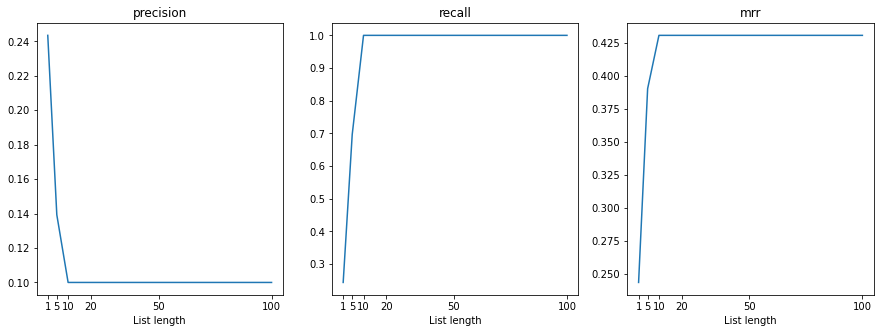

In [ ]:
# show separate plots per metric
fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
res_list_t = list(zip(*res_list))
for midx, metric in enumerate(METRICS):
    mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
    ax = axes[midx]
    ax.plot(topn_list, mvalues)
    ax.set_title(metric)
    ax.set_xticks(topn_list)
    ax.set_xlabel('List length')

<a id='next-item_profile_length'></a>

### 5.2 Evaluation for different user profile lengths

In [ ]:
given_k_list = [1, 2, 3, 4]
LOOK_AHEAD = 1
STEP = 1
TOPN = 10

In [ ]:
# ensure that all sequences have the same minimum length 
test_sequences, test_users = get_test_sequences_and_users(test_data, max(given_k_list), train_data['user_id'].values) # we need user ids now!
print('{} sequences available for evaluation ({} users)'.format(len(test_sequences), len(np.unique(test_users))))

3670 sequences available for evaluation (3670 users)


In [ ]:
res_list = []

for gk in given_k_list:
    print('Evaluating profiles having length: {}'.format(gk))
    res_tmp = evaluation.sequential_evaluation(recommender,
                                               test_sequences=test_sequences,
                                               users=test_users,
                                               given_k=gk,
                                               look_ahead=LOOK_AHEAD,
                                               evaluation_functions=METRICS.values(),
                                               top_n=TOPN,
                                               scroll=False,  # here we stop at each profile length
                                               step=STEP)
    mvalues = list(zip(METRICS.keys(), res_tmp))
    res_list.append((gk, mvalues))

Evaluating profiles having length: 1


100%|██████████| 3670/3670 [00:14<00:00, 254.37it/s]


Evaluating profiles having length: 2


100%|██████████| 3670/3670 [00:16<00:00, 226.60it/s]


Evaluating profiles having length: 3


100%|██████████| 3670/3670 [00:18<00:00, 194.68it/s]


Evaluating profiles having length: 4


100%|██████████| 3670/3670 [00:21<00:00, 171.07it/s]


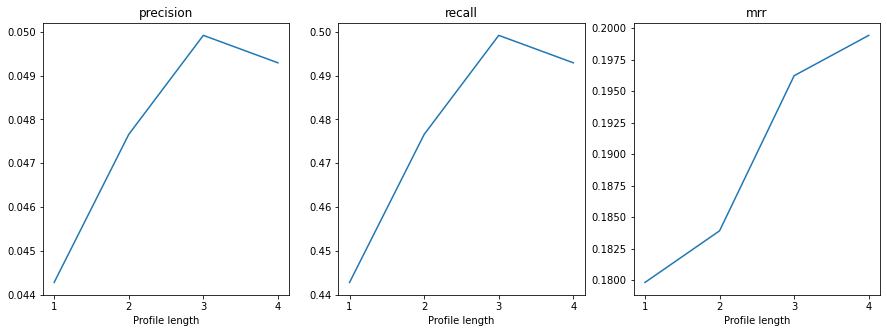

In [ ]:
# show separate plots per metric
fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
res_list_t = list(zip(*res_list))
for midx, metric in enumerate(METRICS):
    mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
    ax = axes[midx]
    ax.plot(given_k_list, mvalues)
    ax.set_title(metric)
    ax.set_xticks(given_k_list)
    ax.set_xlabel('Profile length')